# XGBoost Most Important

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb

import matplotlib.pyplot as plt 
import seaborn as sns
import ppscore as pps

## Read in and Split Data

In [2]:
# read in data
data = pd.read_csv('../data/business_closures_data.csv')
data.head()

,merchants_all,FIPS,State,County,Deaths,Years of Potential Life Lost Rate,% Fair or Poor Health,Average Number of Physically Unhealthy Days,Average Number of Mentally Unhealthy Days,% Low Birthweight,...,% households wo car,Number of Hospitals,% disabled,% Without Health Insurance,% Limited English Proficiency,% workers commuting by public transit,% Veterans in Civilian Adult Population,opioid death rate,Presence of Water Violation (dummy Y/N),Other Primary Care Provider Ratio (:1)
0,-1.000000,10001,Delaware,Kent,2425.0,7952.454872,18.955716,4.095031,4.679157,9.144445,...,0.066361,2.0,14.5,7.0,1.879309,1.0,13.039,32.483898,1,1198
1,-1.000000,10003,Delaware,New Castle,6824.0,7701.203301,16.799934,3.772635,4.172026,8.913882,...,0.069685,10.0,11.0,5.9,2.368350,3.9,7.117,40.047556,0,627
2,-0.999999,10005,Delaware,Sussex,3425.0,8084.788322,17.813709,3.721060,4.132735,7.789606,...,0.039040,4.0,14.1,9.1,2.459576,0.5,10.444,31.837967,1,1390
3,0.159189,1001,Alabama,Autauga,791.0,8128.591190,20.882987,4.743889,4.654031,8.619529,...,0.056569,1.0,19.3,10.0,0.653564,0.1,12.283,8.992644,0,2527
4,-1.000000,1003,Alabama,Baldwin,2967.0,7354.122530,17.509134,4.224519,4.304056,8.345003,...,0.035530,4.0,14.0,13.2,1.424538,0.1,11.938,6.421370,0,1787


In [3]:
X = data.drop(["FIPS", "merchants_all", "State", "County"], axis=1)
y = pd.DataFrame(data["merchants_all"])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
len(X.columns)

92

## Dummy Baseline

In [6]:
y_train_mean = y_train.mean()
y_train_mean

merchants_all    48.4539
dtype: float64

In [7]:
(((y_test - y_train_mean)**2).sum())**(.5)

merchants_all    968.88607
dtype: float64

## XGBoost and Feature Importance

In [8]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [9]:
"""
Hyperparameter Tuning from 
https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
"""

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric':"rmse"
}

In [10]:
num_boost_round = 999

In [11]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:1.35995
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:1.24668
[2]	Test-rmse:1.15191
[3]	Test-rmse:1.17899
[4]	Test-rmse:1.15110
[5]	Test-rmse:1.17263
[6]	Test-rmse:1.17916
[7]	Test-rmse:1.22853
[8]	Test-rmse:2.00243
[9]	Test-rmse:1.98822
[10]	Test-rmse:2.02099
[11]	Test-rmse:2.01492
[12]	Test-rmse:2.02985
[13]	Test-rmse:2.04757
[14]	Test-rmse:2.04065
Stopping. Best iteration:
[4]	Test-rmse:1.15110



In [12]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1362.860991,621.373725,1050.143527,1464.283219


In [13]:
cv_results['test-rmse-mean'].min()

1050.1435265999999

### Tune max_depth and min_child_weight

In [14]:
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
]

In [15]:
# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with max_depth=9, min_child_weight=5
	rmse 953.4652686 for 0 rounds
CV with max_depth=9, min_child_weight=6
	rmse 964.6155684000001 for 0 rounds
CV with max_depth=9, min_child_weight=7
	rmse 964.5481629999998 for 0 rounds
CV with max_depth=10, min_child_weight=5
	rmse 953.4659353999999 for 0 rounds
CV with max_depth=10, min_child_weight=6
	rmse 964.6162764000001 for 0 rounds
CV with max_depth=10, min_child_weight=7
	rmse 964.5483522000001 for 0 rounds
CV with max_depth=11, min_child_weight=5
	rmse 953.4659902 for 0 rounds
CV with max_depth=11, min_child_weight=6
	rmse 964.6163983999999 for 0 rounds
CV with max_depth=11, min_child_weight=7
	rmse 964.548416 for 0 rounds
Best params: 9, 5, rmse: 953.4652686


In [16]:
params['max_depth'] = 9
params['min_child_weight'] = 5

### Tune subsample and colsample

In [17]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(7,11)]
]

In [ ]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, rmse: {}".format(best_params[0], best_params[1], min_rmse))

CV with subsample=1.0, colsample=1.0
	rmse 953.4652626 for 0 rounds
CV with subsample=1.0, colsample=0.9
	rmse 953.7807954 for 0 rounds
CV with subsample=1.0, colsample=0.8
	rmse 953.3430421999999 for 0 rounds
CV with subsample=1.0, colsample=0.7
	rmse 1005.4020844 for 1 rounds
CV with subsample=0.9, colsample=1.0


In [19]:
params['subsample'] = 0.8
params['colsample_bytree'] = 0.8

### Tune eta

In [20]:
min_rmse = float("Inf")
best_params = None
for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(params, dtrain, num_boost_round=num_boost_round, seed=42, nfold=5, metrics=['rmse'], early_stopping_rounds=10)
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\trmse {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, rmse: {}".format(best_params, min_rmse))

CV with eta=0.3
	rmse 936.1493918000002 for 0 rounds

CV with eta=0.2
	rmse 905.2825165999999 for 0 rounds

CV with eta=0.1
	rmse 878.2439414 for 0 rounds

CV with eta=0.05
	rmse 866.7115402000002 for 0 rounds

CV with eta=0.01
	rmse 858.8385566000001 for 0 rounds

CV with eta=0.005
	rmse 858.1282611999999 for 0 rounds

Best params: 0.005, rmse: 858.1282611999999


In [21]:
params['eta'] = .005

In [22]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:0.96981
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:1.15038
[2]	Test-rmse:1.28764
[3]	Test-rmse:1.45136
[4]	Test-rmse:1.54357
[5]	Test-rmse:1.54696
[6]	Test-rmse:1.58842
[7]	Test-rmse:3.32220
[8]	Test-rmse:3.36002
[9]	Test-rmse:4.52682
[10]	Test-rmse:4.55710
Stopping. Best iteration:
[0]	Test-rmse:0.96981



In [23]:
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

Best RMSE: 0.97 in 1 rounds


### Get and save best model

In [24]:
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")]
)

[0]	Test-rmse:0.96981


In [25]:
best_model.save_model("my_model.model")

In [26]:
(mean_squared_error(best_model.predict(dtest), y_test))**.5

0.9698124210293413

### Feature Importance

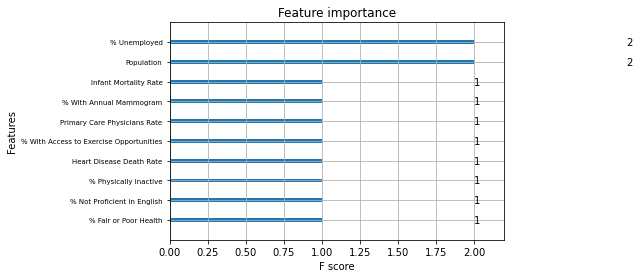

In [27]:
xgb.plot_importance(best_model)
plt.rcParams['figure.figsize'] = [50, 50]
plt.yticks(size = 7)
plt.show()

### The following are the 10 most important features:
1. % Unemployed
2. Population
3. Infant Mortality Rate
4. % With Annual Mammogram
5. Primary Care Physicians Rate
6. % With Access to Exercise Opportunities
7. Heart Disease Death Rate
8. % Physically Inactive
9. % Not Proficient in English
10. % Fair or Poor Health

### Correlation

In [30]:
X_x = X.filter(['% Unemployed', 'Population', 'Infant Mortality Rate', 
               '% With Annual Mammogram', 'Primary Care Physicians Rate', 
                '% With Access to Exercise Opportunities', 'Heart Disease Death Rate', 
                '% Physically Inactive', '% Not Proficient in English', 
                '% Fair or Poor Health'])

In [31]:
Correlation_Matrix=X_x.corr().abs()
Correlation_Matrix

,% Unemployed,Population,Infant Mortality Rate,% With Annual Mammogram,Primary Care Physicians Rate,% With Access to Exercise Opportunities,Heart Disease Death Rate,% Physically Inactive,% Not Proficient in English,% Fair or Poor Health
% Unemployed,1.000000,0.041912,0.089913,0.282908,0.185080,0.154723,0.279393,0.301652,0.140291,0.462800
Population,0.041912,1.000000,0.130590,0.021304,0.182352,0.322725,0.163326,0.233380,0.368822,0.080762
Infant Mortality Rate,0.089913,0.130590,1.000000,0.028044,0.027333,0.057797,0.202580,0.148452,0.022151,0.242292
% With Annual Mammogram,0.282908,0.021304,0.028044,1.000000,0.270461,0.240126,0.307571,0.255040,0.258377,0.461083
Primary Care Physicians Rate,0.185080,0.182352,0.027333,0.270461,1.000000,0.435792,0.329151,0.418886,0.015704,0.305645
% With Access to Exercise Opportunities,0.154723,0.322725,0.057797,0.240126,0.435792,1.000000,0.431541,0.516668,0.175775,0.413418
Heart Disease Death Rate,0.279393,0.163326,0.202580,0.307571,0.329151,0.431541,1.000000,0.650439,0.182042,0.601169
% Physically Inactive,0.301652,0.233380,0.148452,0.255040,0.418886,0.516668,0.650439,1.000000,0.135852,0.630355
% Not Proficient in English,0.140291,0.368822,0.022151,0.258377,0.015704,0.175775,0.182042,0.135852,1.000000,0.232412
% Fair or Poor Health,0.462800,0.080762,0.242292,0.461083,0.305645,0.413418,0.601169,0.630355,0.232412,1.000000


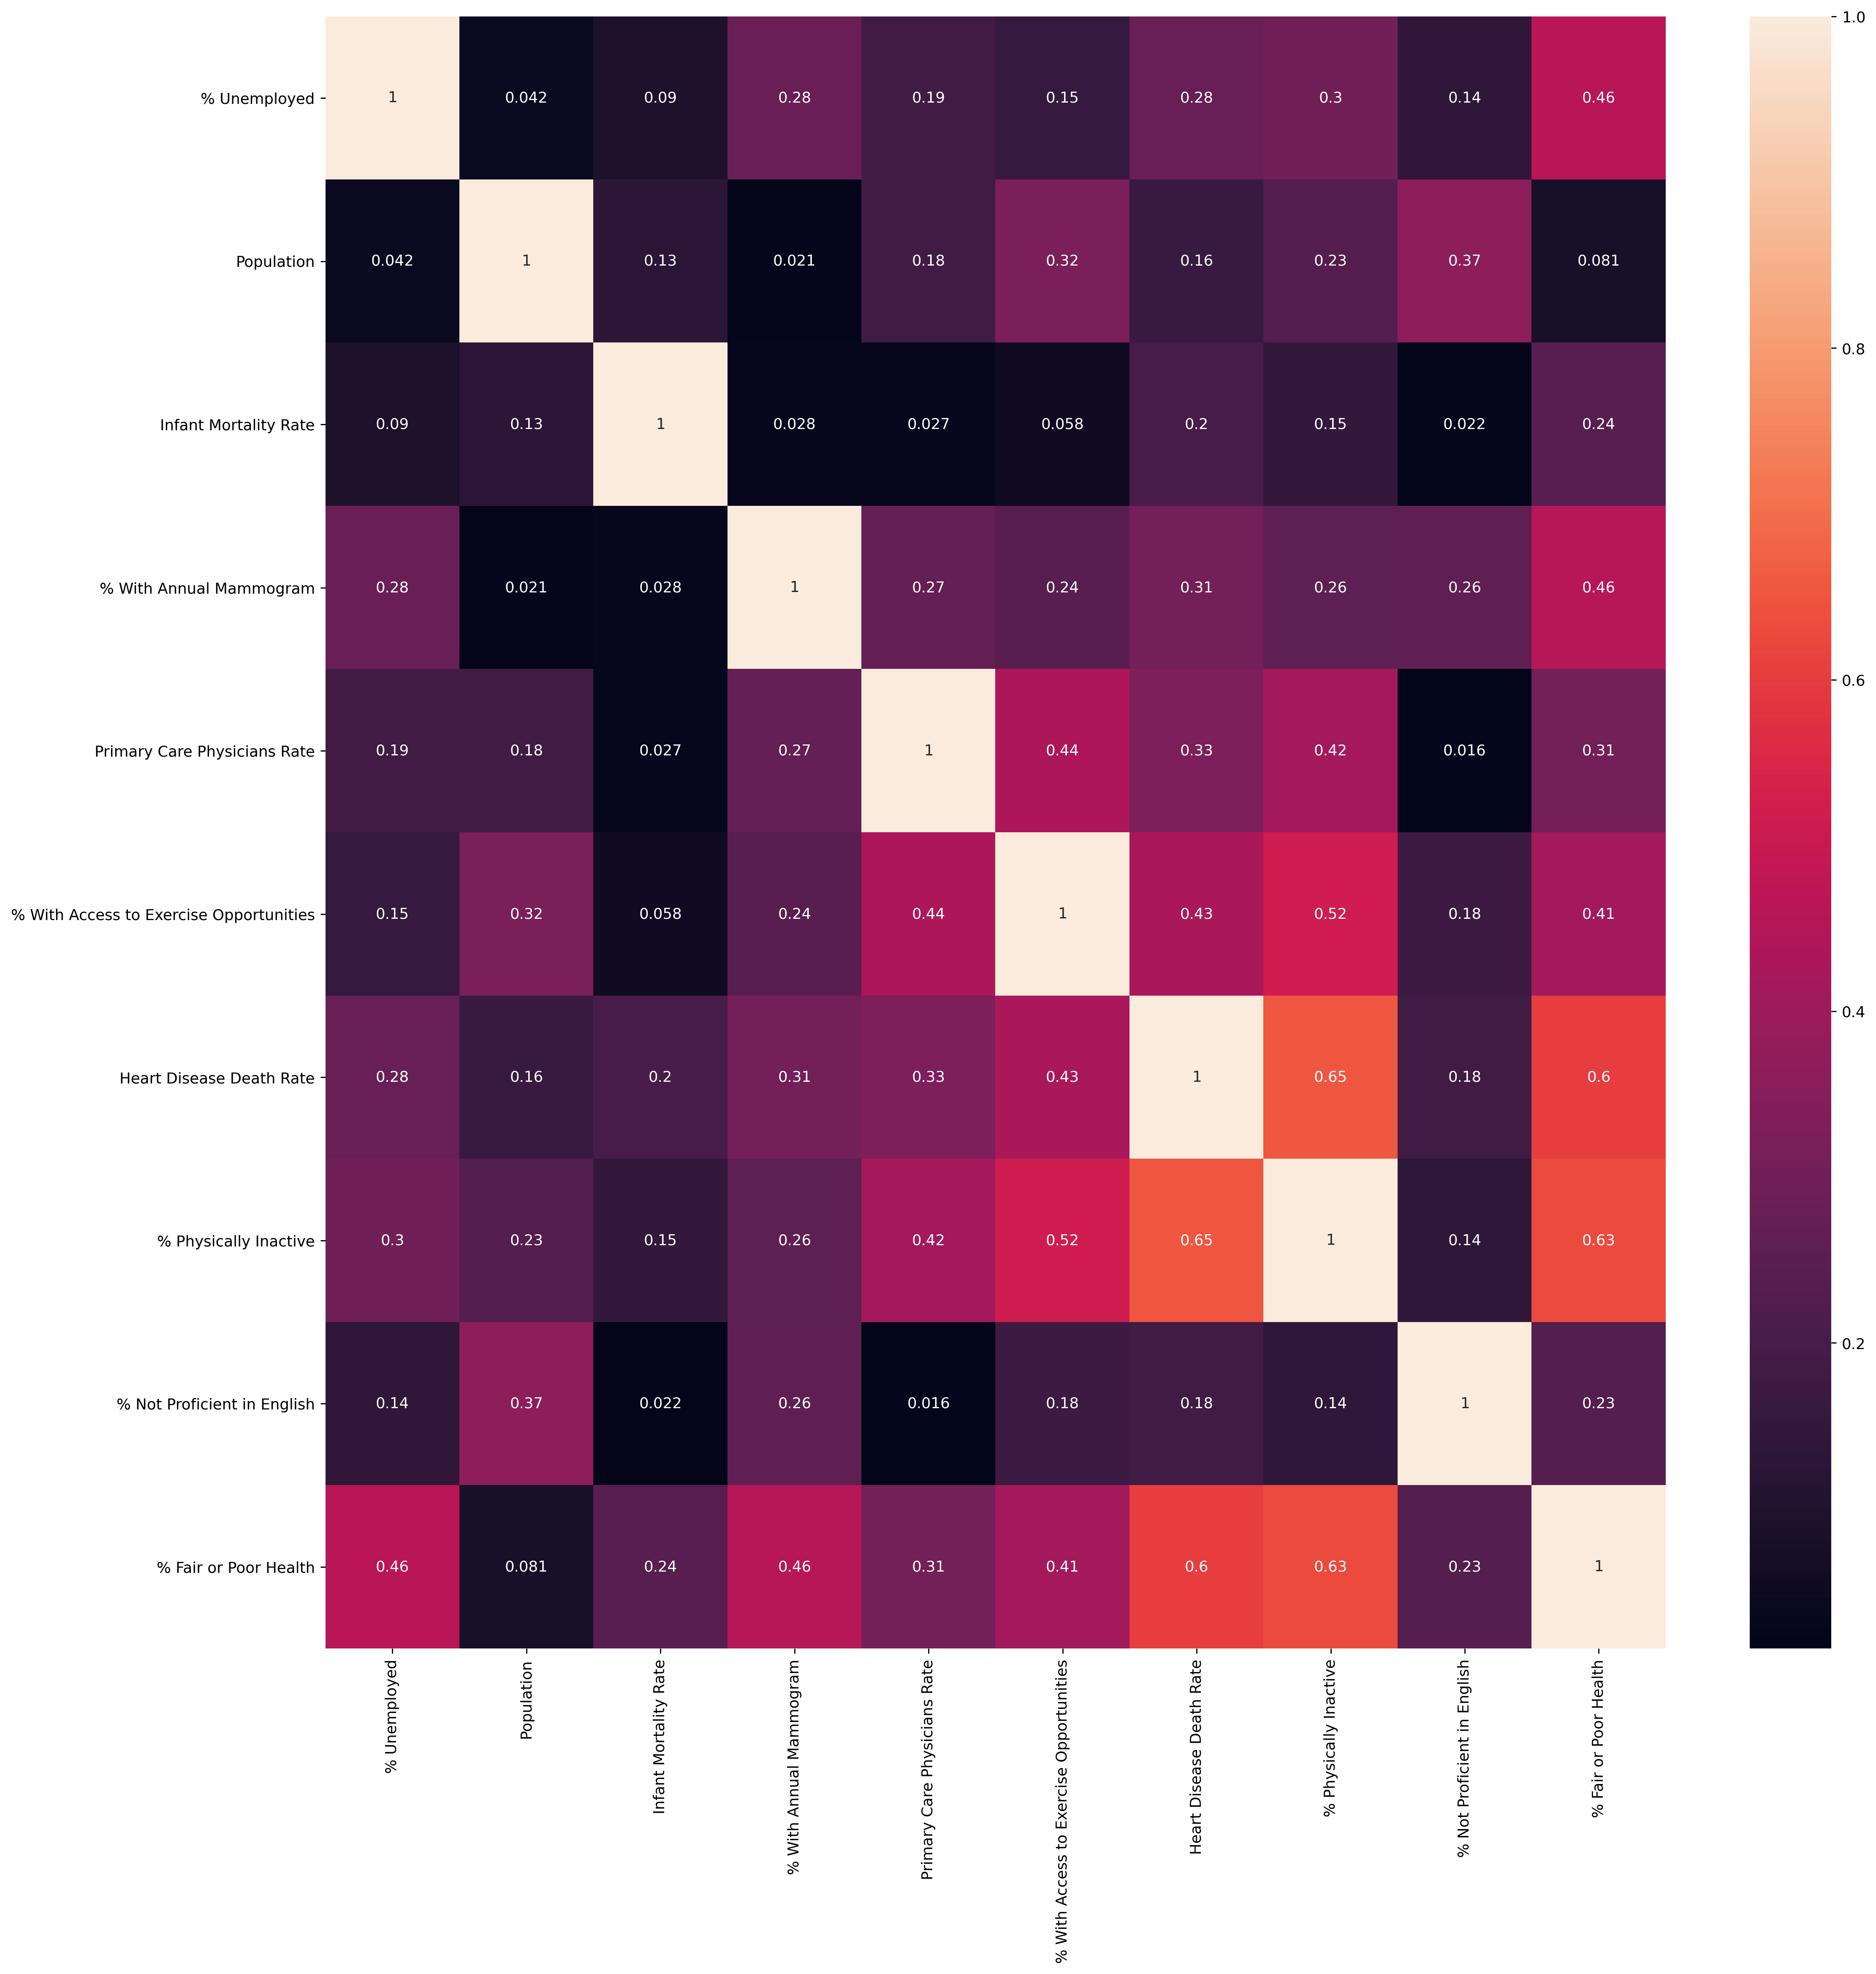

In [32]:
plt.figure(figsize=[20,20],dpi=256)
sns.heatmap(Correlation_Matrix, annot=True)

plt.show()

In [33]:
plt.figure(figsize=[20,20],dpi=400)
a = pps.matrix(X_x).pivot(columns='x', index='y', values='ppscore')
sns.heatmap(a, vmin=0, vmax=1, cmap="Blues", linewidths=0.5, annot=True)
plt.show()